    V Dataset 2. See README.txt for more details
    SEQ has two monitors. Mon 1 is just after Fermi chopper. Mon 2 is after the detectors.
    LM1 = 18.26
    mcvine neutron recorder at 19.9

# Prepare

In [1]:
cd /SNS/users/lj7/dv/sns-chops/resolution/SEQUOIA/

/SNS/users/lj7/dv/sns-chops/resolution/SEQUOIA


In [2]:
#Program to load Vanadium or empty Can powder files and perform a constant-Q cut along the middle Q to look at energy resolution and intensity.
import matplotlib.pyplot as plt
from mantid import plots
from mantid.simpleapi import Load, ConvertToMD, BinMD, ConvertUnits, Rebin
from matplotlib.colors import LogNorm
import numpy as np
import mantid.simpleapi as msa
from mantid import mtd

/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from mcni.utils import conversion as C

In [4]:
%matplotlib notebook

In [5]:
instrument = 'SEQ'
IPTS = 22666
RunNumbers=range(168945, 169105+1)
print(RunNumbers)
rawdatadir = "/SNS/%s/IPTS-%s/nexus" % (instrument, IPTS)
autoreducedir="/SNS/%s/IPTS-%s/shared/autoreduce/" % (instrument, IPTS)

[168945, 168946, 168947, 168948, 168949, 168950, 168951, 168952, 168953, 168954, 168955, 168956, 168957, 168958, 168959, 168960, 168961, 168962, 168963, 168964, 168965, 168966, 168967, 168968, 168969, 168970, 168971, 168972, 168973, 168974, 168975, 168976, 168977, 168978, 168979, 168980, 168981, 168982, 168983, 168984, 168985, 168986, 168987, 168988, 168989, 168990, 168991, 168992, 168993, 168994, 168995, 168996, 168997, 168998, 168999, 169000, 169001, 169002, 169003, 169004, 169005, 169006, 169007, 169008, 169009, 169010, 169011, 169012, 169013, 169014, 169015, 169016, 169017, 169018, 169019, 169020, 169021, 169022, 169023, 169024, 169025, 169026, 169027, 169028, 169029, 169030, 169031, 169032, 169033, 169034, 169035, 169036, 169037, 169038, 169039, 169040, 169041, 169042, 169043, 169044, 169045, 169046, 169047, 169048, 169049, 169050, 169051, 169052, 169053, 169054, 169055, 169056, 169057, 169058, 169059, 169060, 169061, 169062, 169063, 169064, 169065, 169066, 169067, 169068, 169069,

# debug

In [6]:
RunNumber = RunNumbers[0]
path = '/SNS/SEQ/IPTS-%s/nexus/SEQ_%s.nxs.h5' % (IPTS, RunNumber)
w = msa.LoadEventNexus(path)
mons = msa.LoadNexusMonitors(path)

In [7]:
mons.getNumberHistograms()

2

In [8]:
RunParams=w.getRun()
Energy = RunParams['EnergyRequest'].getStatistics().mean
v = C.e2v(Energy)
print Energy, v

4.0 874.7866274484295


In [9]:
LM1 = 18.26
t = LM1/v*1e6
t2 = t % (1e6/60)
print t2

4206.994894965363


In [10]:
mon1 = mons.getSpectrum(0)
tofs = mon1.getTofs()
weights = mon1.getWeights()
intensities, tofbbs = np.histogram(tofs, weights=weights, bins=100, range=(t2*.8, t2*1.2))
tofcenters = (tofbbs[1:]+tofbbs[:-1])/2

<IPython.core.display.Javascript object>


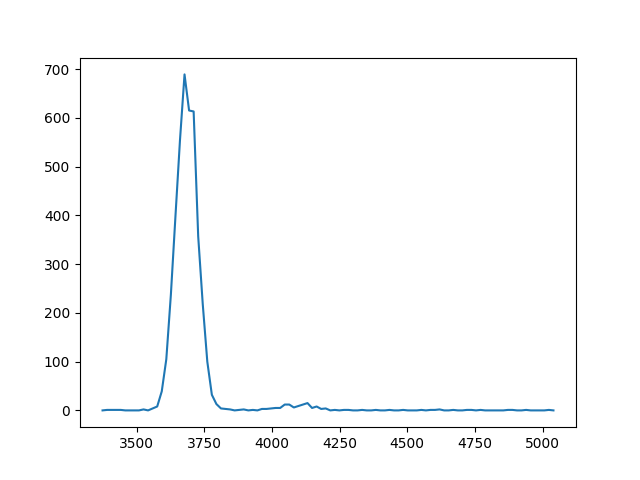

In [11]:
plt.figure()
plt.plot(tofcenters, intensities)

# gather data
**This can be skipped the 2nd time running this notebook**

In [7]:
LM1 = 18.26

In [8]:
%%time
PlotTag=0

data_table = {}

import tqdm
for RunNumber in tqdm.tqdm(RunNumbers):
    # print (RunNumber)
    path = '/SNS/SEQ/IPTS-%s/nexus/SEQ_%s.nxs.h5' % (IPTS, RunNumber)
    w = msa.LoadEventNexus(path)
    mons = msa.LoadNexusMonitors(path)
    RunParams=w.getRun()
    Energy=RunParams["EnergyRequest"].getStatistics().mean
    v = C.e2v(Energy)
    t = LM1/v*1e6 % (1.e6/60)
    mon1 = mons.getSpectrum(0)
    tofs = mon1.getTofs()
    weights = mon1.getWeights()
    intensities, tofbbs = np.histogram(tofs, weights=weights, bins=100, range=(t*.8, t*1.2))
    tofcenters = (tofbbs[1:]+tofbbs[:-1])/2
    totscatt = w.getNumberEvents()
    duration = RunParams['duration'].value
    data_table[RunNumber] = (tofcenters, intensities), totscatt, duration
    # break
    continue

100%|██████████| 161/161 [20:45<00:00,  6.16s/it]

CPU times: user 20min 48s, sys: 57.5 s, total: 21min 46s
Wall time: 20min 45s


## Save

In [9]:
import pickle as pkl

In [10]:
pkl.dump(data_table, open('V_Cali_MonitorInt_IPTS_22666_datatable.pkl', 'w'))

# Load data from saved file

In [8]:
import pickle as pkl
data_table = pkl.load(open('./V_Cali_MonitorInt_IPTS_22666_datatable.pkl'))

examine data

<IPython.core.display.Javascript object>


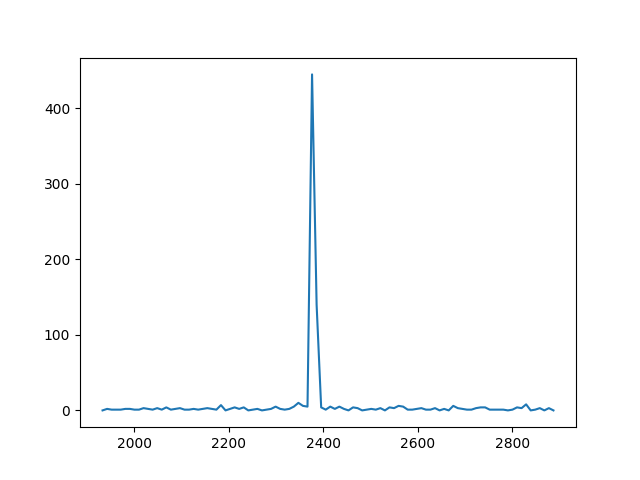

In [11]:
(tof,I), totscatt, duration  =  data_table[RunNumbers[50]]
plt.figure()
plt.plot(tof, I)

In [12]:
intensity_data = [(k, I.sum(), totscatt, duration) for k, ((tof, I), totscatt, duration) in data_table.items()]

In [13]:
intensity_data = np.array(intensity_data)

In [17]:
np.savetxt('V_Cali_MonitorInt_IPTS_22666.dat', intensity_data)

# Inspect 